COMP5930M Scientific Computation - Tutorial 6  \\
Time-stepping methods

To experiment with time-stepping methods, we consider some standard ODEs (ordinary differential equations) as test cases:

1) Linear test ODE: $\frac{du}{dt} = \lambda u(t)$ for $t > 0$, $u(0) = u_0$ and $Re(\lambda) < 0$.


2) Linear ODE system with a periodic orbit:
$$\frac{du_1}{dt} = u_2(t) $$
$$\frac{du_2}{dt} = -u_1(t)$$
for $t > 0$, $u(0) = 1$ and $v(0) = 0$.

3) Nonlinear ODE system (``Brusselator"):
$$
\begin{aligned}
\frac{du_1}{dt} &= a + u_1(t)^2 u_2(t) - bu_1(t) - u_1(t)  \\
\frac{du_2}{dt} &= b u_1(t) - u_1(t)^2 u_2(t)
\end{aligned}
$$
for $t > 0$, $u_1(0) = u_1^0$ and $u_2(0) = u_2^0$, where $a,b$ are positive constants. This is a theoretical model for a type of autocatalytic reaction in chemistry.  

These basic problems exhibit many of the issues with time-stepping methods that we can also experience when solving PDEs, but are simple enough to be easily analysed.

Linear ODE:

In [422]:
def linearODE( u, t ):
  lamb = -10
  f = lamb * u

  return(f)

Periodic ODE:

In [423]:
import numpy as np

def periodicODE( u, t ):
  f = np.zeros((2,1), dtype=np.float64)
  f[0] = u[1]
  f[1] = -u[0]
  return(f)

Brusselator:

In [424]:
import numpy as np

def brusselator( u, t ):
  # Brusselator with an unstable solution
  a = 1
  b = 3
  f = np.zeros((2,1), dtype=np.float64)
  f[0] = a + u[0]**2 * u[1] - b*u[0] - u[0]
  f[1] = b*u[0] - u[0]**2 * u[1]
  return(f)

To simplify the Newton implementation, we will use the finite-difference Jacobian algorithm:

In [425]:
import numpy as np
import copy

def fdJacobian(x,n,fnon,F0,*fnonargs):

  J = np.zeros((n,n), dtype=np.float64)
  h = 10e-8

  for k in range(0,n):
    xb = copy.deepcopy(x)
    xb[k] = xb[k] + h

    F = eval(fnon)(xb,*fnonargs)

    for i in range(0,n):
        J[i,k] = (F[i] - F0[i]) / h

  return J

We now introduce the main time-stepping for solving these ODEs:

In [426]:
import math

def ODEsolver( f, solver, dt, T, u0 ):

  # Implicit Euler in time, finite difference in space
  # numerical model for the Fisher Equation
  #  function sols = fisherModel( dtIn, nTimeSteps, mIn )
  # Input:  f      - nonlinear function u'(t) = f(u(t),t)
  #         solver - defines with time-stepping method to use
  #         dt     - time-step
  #         T      - final time
  #         u0     - initial value
  # Output: u      - discrete solution vector(s)

  nTimeSteps = math.ceil(T/dt)
  n = u0.size

  # Prepare solution vector(s)
  sols = np.zeros((n,nTimeSteps), dtype=np.float64)

  # Initialise with the initial values
  uPrev = u0

  for m in range(0,n):
    sols[m,0] = u0[m]


  # Time stepping loop
  for k in range( 1, nTimeSteps ):

    # Call the Newton solver for the chosen time-stepping scheme passing the
    # function f(u(t),t) as an argument

    # Current time step
    t = k * dt

    if (solver == "explicitEuler"):
      # No Newton required, just an explicit update step
      u = uPrev + dt * eval(f)(uPrev,t)

    else:
      # Call Newton to solve the nonlinear system
      u = myNewtonSys(solver, "fdJacobian", uPrev, 1e-6, 10, f, t, dt, uPrev)

    # Update the initial guess
    u0 = u
    uPrev = u

    for m in range(0,n):
      sols[m,k] = u[m]

  return sols;

The Newton solver remains similar to before:

In [427]:
import numpy as np
from numpy.linalg import norm

def myNewtonSys(fnon, jac, x0, tol, maxk, *fnonargs):
    # fnon     - name of the nonlinear function f(x)
    # jac      - name of the Jacobian function J(x)
    # x0       - initial guess for the solution x0
    # tol      - stopping tolerance for Newton's iteration
    # maxk     - maximum number of Newton iterations before stopping
    # fnonargs - optional arguments that will be passed to the nonlinear function (useful for additional function parameters)

    k = 0
    x = x0

    F = eval(fnon)(x,*fnonargs)
    n = F.size

    # Main Newton loop
    while (norm(F,2) > tol and k <= maxk):
        # Evaluate Jacobian matrix
        J = eval(jac)(x,n,fnon,F,*fnonargs)

        # Take Newton step by solving the tangent problem
        delta = np.linalg.solve(J,-F)
        x = x + delta

        F = eval(fnon)(x,*fnonargs)

        k += 1

    if (k >= maxk):
        print('Not converged')
    else:
        return x

Each time-stepping method results in a different nonlinear system so each is implemented separately:

In [428]:
def implicitEuler(u, fun, t, dt, uPrev):
  # F(u) = (u - uPrev) / dt - f(u) = 0
  n = u.size
  f = eval(fun)(u,t)
  F = (u-uPrev)/dt - f
  return(F)

def implicitMidpoint(u, fun, t, dt, uPrev):
  # F(u) = (u - uPrev) / dt - f(0.5*(u + uPrev)) = 0
  n = u.size
  f = (u-uPrev)/dt - eval(fun)(0.5*(u+uPrev),t)
  return(f)

def trapezoidalRule(u, fun, t, dt, uPrev):
  # F(u) = (u - uPrev) / dt - 0.5* [f(u) + f(uPrev)] = 0
  n = u.size
  f = (u-uPrev)/dt - 0.5* (eval(fun)(u,t) + eval(fun)(uPrev,t))
  return(f)

We now solve the linear test problem with different time-steps and compare the solution against the known exact solution $u(t) = \exp(-10 t)$:

In [429]:
u1 = ODEsolver( "linearODE", "implicitEuler", 0.1, 1, np.array([1.]));
u2 = ODEsolver( "linearODE", "implicitEuler", 0.05, 1, np.array([1.]));
u3 = ODEsolver( "linearODE", "implicitEuler", 0.01, 1, np.array([1.]));

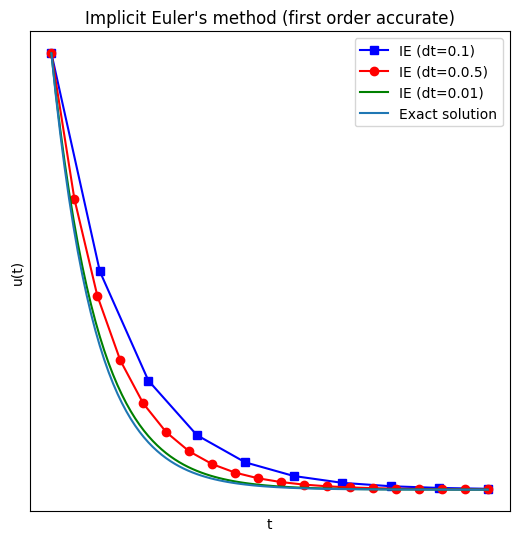

In [430]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
t1 = np.linspace(0, 1, 10)
t2 = np.linspace(0, 1, 20)
t3 = np.linspace(0, 1, 100)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(t1, u1.flatten(), label="IE (dt=0.1)", marker='s', c='b', ls='-')
ax.plot(t2, u2.flatten(), label="IE (dt=0.0.5)", marker='o', c='r', ls='-')
ax.plot(t3, u3.flatten(), label="IE (dt=0.01)", c='g', ls='-')
ax.plot(t3, np.exp(-10*t3), label="Exact solution")
ax.set_xlabel('t')
ax.set_ylabel('u(t)')
ax.legend()
ax.set(title="Implicit Euler's method (first order accurate)", aspect=1, xticks=[], yticks=[])
plt.show()

Each numerical solution is stable (converges exponentially to 0), but for larger $\Delta t$ the error accumulates over time. For $\Delta = 0.01$ we are reasonably close to the exact solution.

What happens if we try to use the explicit Euler's method?

In [445]:
u1 = ODEsolver( "linearODE", "explicitEuler", 0.2, 1, np.array([1.]));
u2 = ODEsolver( "linearODE", "explicitEuler", 0.1, 1, np.array([1.]));
u3 = ODEsolver( "linearODE", "explicitEuler", 0.05, 1, np.array([1.]));

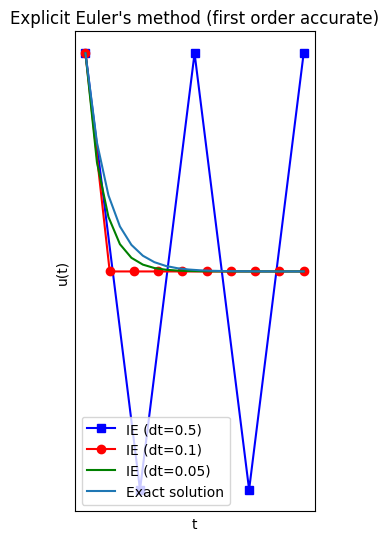

In [446]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
t1 = np.linspace(0, 1, 5)
t2 = np.linspace(0, 1, 10)
t3 = np.linspace(0, 1, 20)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(t1, u1.flatten(), label="IE (dt=0.5)", marker='s', c='b', ls='-')
ax.plot(t2, u2.flatten(), label="IE (dt=0.1)", marker='o', c='r', ls='-')
ax.plot(t3, u3.flatten(), label="IE (dt=0.05)", c='g', ls='-')
ax.plot(t3, np.exp(-10*t3), label="Exact solution")
ax.set_xlabel('t')
ax.set_ylabel('u(t)')
ax.legend()
ax.set(title="Explicit Euler's method (first order accurate)", aspect=1, xticks=[], yticks=[])
plt.show()

We see that for $\Delta t = 0.1$ the solution collapses to zero after one time-step and the solution for $\Delta t = 0.05$ is quite inaccurate. For $\Delta t > 0.1$ (boundary of A-stability region in the complex plane) the solution starts to oscillate. Thus explicit methods must obey the A-stability condition, otherwise we obtain an unstable solution.

Let's try the implicit midpoint method next:

In [431]:
initvalue = np.array([1.])

u1 = ODEsolver( "linearODE", "implicitMidpoint", 0.1, 1, initvalue);
u2 = ODEsolver( "linearODE", "implicitMidpoint", 0.05, 1, initvalue);
u3 = ODEsolver( "linearODE", "implicitMidpoint", 0.01, 1, initvalue);

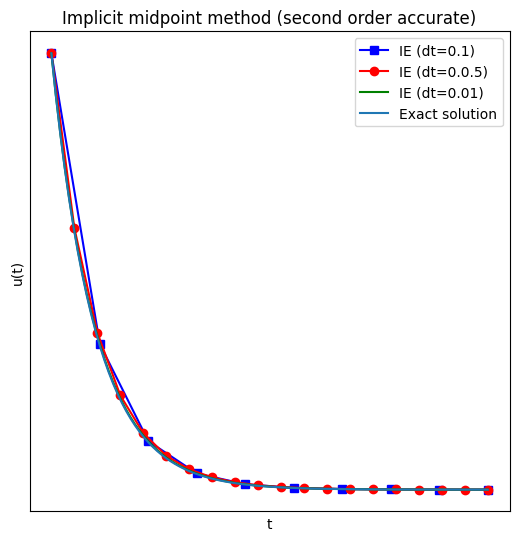

In [432]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
t1 = np.linspace(0, 1, 10)
t2 = np.linspace(0, 1, 20)
t3 = np.linspace(0, 1, 100)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(t1, u1.flatten(), label="IE (dt=0.1)", marker='s', c='b', ls='-')
ax.plot(t2, u2.flatten(), label="IE (dt=0.0.5)", marker='o', c='r', ls='-')
ax.plot(t3, u3.flatten(), label="IE (dt=0.01)", c='g', ls='-')
ax.plot(t3, np.exp(-10*t3), label="Exact solution")
ax.set_xlabel('t')
ax.set_ylabel('u(t)')
ax.legend()
ax.set(title="Implicit midpoint method (second order accurate)", aspect=1, xticks=[], yticks=[])
plt.show()

We can see that with the same time-steps the solution error is much smaller compared to implicit Euler.

Next we will look at the periodic ODE system:

In [433]:
u1 = ODEsolver( "periodicODE", "implicitEuler", 0.1, 2.*math.pi, np.array([[1.], [0.]]));
u2 = ODEsolver( "periodicODE", "implicitEuler", 0.05, 2.*math.pi, np.array([[1.], [0.]]));
u3 = ODEsolver( "periodicODE", "implicitEuler", 0.01, 2.*math.pi, np.array([[1.], [0.]]));

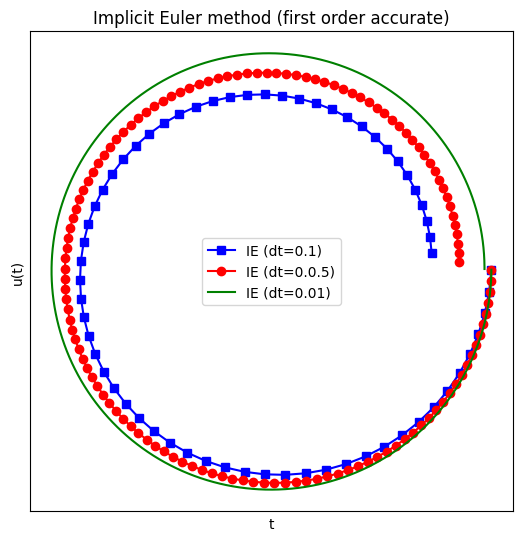

In [434]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

fig=plt.figure()
ax=fig.add_axes([-1,-1,1,1])
ax.plot(u1[0], u1[1], label="IE (dt=0.1)", marker='s', c='b', ls='-')
ax.plot(u2[0], u2[1], label="IE (dt=0.0.5)", marker='o', c='r', ls='-')
ax.plot(u3[0], u3[1], label="IE (dt=0.01)", c='g', ls='-')
#ax.plot(t3, np.exp(-2*t3), label="Exact solution")
ax.set_xlabel('t')
ax.set_ylabel('u(t)')
ax.legend()
ax.set(title="Implicit Euler method (first order accurate)", aspect=1, xticks=[], yticks=[])
plt.show()

We expect a period solution (perfect circle), but already after one rotation the numerical solution diverges from its correct trajectory.

When the solution vector tends to zero over time (even if this is not the correct solution), the method is called *dissipative*. The implicit Euler's method is a dissipative method, which is not a good property to have when the solution is periodic.

Now let's compare with the implicit midpoint method:

In [435]:
u1 = ODEsolver( "periodicODE", "implicitMidpoint", 0.1, 2.*math.pi, np.array([[1.], [0.]]));
u2 = ODEsolver( "periodicODE", "implicitMidpoint", 0.05, 2.*math.pi, np.array([[1.], [0.]]));
u3 = ODEsolver( "periodicODE", "implicitMidpoint", 0.01, 2.*math.pi, np.array([[1.], [0.]]));

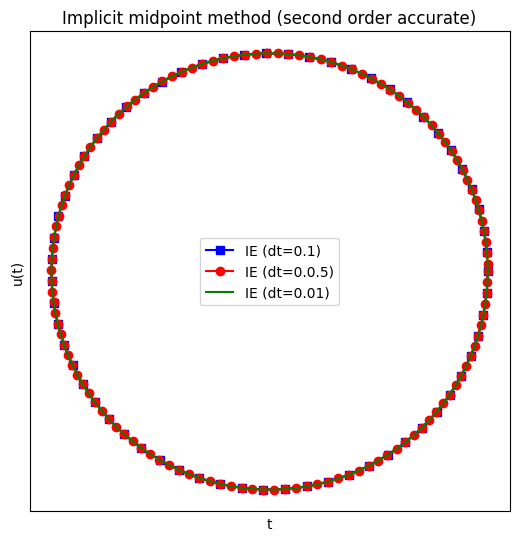

In [436]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

fig=plt.figure()
ax=fig.add_axes([-1,-1,1,1])
ax.plot(u1[0], u1[1], label="IE (dt=0.1)", marker='s', c='b', ls='-')
ax.plot(u2[0], u2[1], label="IE (dt=0.0.5)", marker='o', c='r', ls='-')
ax.plot(u3[0], u3[1], label="IE (dt=0.01)", c='g', ls='-')
#ax.plot(t3, np.exp(-2*t3), label="Exact solution")
ax.set_xlabel('t')
ax.set_ylabel('u(t)')
ax.legend()
ax.set(title="Implicit midpoint method (second order accurate)", aspect=1, xticks=[], yticks=[])
plt.show()

The numerical solution follows the exact trajectory for all $\Delta t > 0$! This is not by accident.

The midpoint method has a property called *symplecticity*, which roughly speaking means that it conserves the numerical energy of a system that has a conservation property (in this case angular momentum). Symplectic integrators are preferred when solving systems of physical conservation laws.

Let's finally look at the Brusselator:

In [437]:
u1 = ODEsolver( "brusselator", "implicitEuler", 0.1, 30, np.array([[1.], [1.]]));
u2 = ODEsolver( "brusselator", "implicitEuler", 0.05, 30, np.array([[1.], [1.]]));
u3 = ODEsolver( "brusselator", "implicitEuler", 0.01, 30, np.array([[1.], [1.]]));

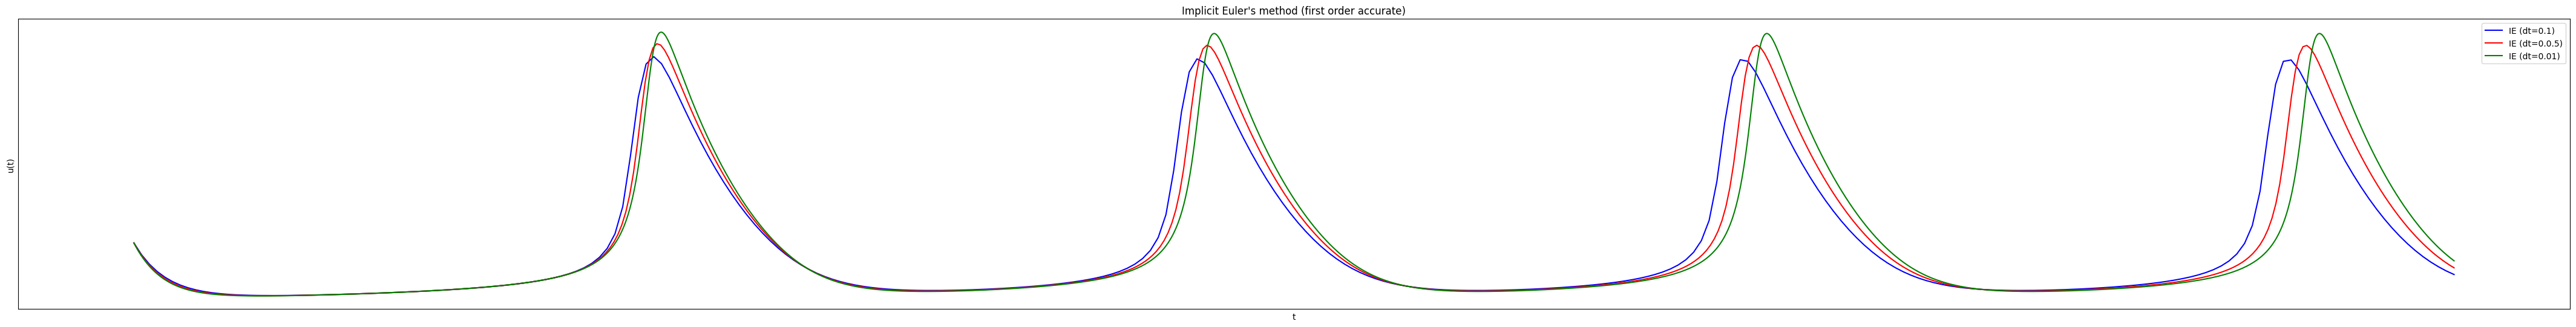

In [438]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
t1 = np.linspace(0, 30, 300)
t2 = np.linspace(0, 30, 600)
t3 = np.linspace(0, 30, 3000)
fig=plt.figure()
ax=fig.add_axes([0,0,30,1])
ax.plot(t1, u1[0], label="IE (dt=0.1)", c='b', ls='-')
ax.plot(t2, u2[0], label="IE (dt=0.0.5)", c='r', ls='-')
ax.plot(t3, u3[0], label="IE (dt=0.01)", c='g', ls='-')

ax.set_xlabel('t')
ax.set_ylabel('u(t)')
ax.legend()
ax.set(title="Implicit Euler's method (first order accurate)", aspect=1, xticks=[], yticks=[])
plt.show()

We plot only the first component of the solution. The solution is a periodic burst reaction followed by a period of no reaction. Over time, the numerical method starts to diverge if the time step is too large.

Let's compare this with the implicit midpoint method:

In [439]:
u1 = ODEsolver( "brusselator", "implicitMidpoint", 0.1, 30, np.array([[1.], [1.]]));
u2 = ODEsolver( "brusselator", "implicitMidpoint", 0.05, 30, np.array([[1.], [1.]]));
u3 = ODEsolver( "brusselator", "implicitMidpoint", 0.01, 30, np.array([[1.], [1.]]));

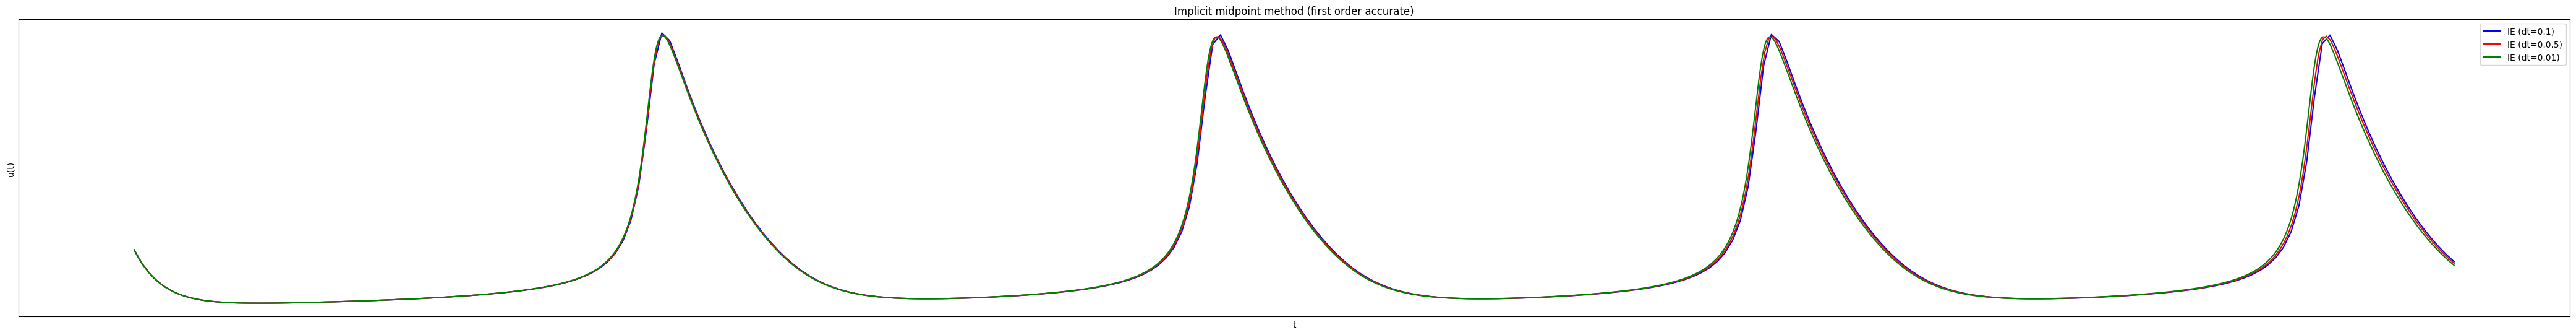

In [440]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
t1 = np.linspace(0, 30, 300)
t2 = np.linspace(0, 30, 600)
t3 = np.linspace(0, 30, 3000)
fig=plt.figure()
ax=fig.add_axes([0,0,30,1])
ax.plot(t1, u1[0], label="IE (dt=0.1)", c='b', ls='-')
ax.plot(t2, u2[0], label="IE (dt=0.0.5)", c='r', ls='-')
ax.plot(t3, u3[0], label="IE (dt=0.01)", c='g', ls='-')

ax.set_xlabel('t')
ax.set_ylabel('u(t)')
ax.legend()
ax.set(title="Implicit midpoint method (first order accurate)", aspect=1, xticks=[], yticks=[])
plt.show()

Again, the second-order symplectic method is much more accurate.